# 08-01 Link Prediction in Random Geometric Graphs

*June 14 2023*  

As a motivating example for graph representation learning, we consider networks where nodes are embedded into a Euclidean space and the topology of the networks is correlated with those node positions. We show how we can use those known node coordinates to predict links.

In [1]:
import scipy as sp
import seaborn as sns
from numpy import linalg as npl
import matplotlib.pyplot as plt

import pandas as pd
from sklearn import metrics

import numpy as np
from scipy.linalg import svd

import torch
import torch_geometric as pyG
import pathpyG as pp

plt.style.use('default')
sns.set_style("whitegrid")

We implement a simple probabilistic generative model to generate networks, where nodes are randomly assigned coordinates in a $d$-dimensional space, and links are generated based on those coordinates. To keep the implementation general, we can pass the dimensionality of the underlying space, a function used to calculate the distance between nodes and a connection rule that is used to generate links based on those distances. We can parametrize the connection rule by passing arbitrary keywords:

In [2]:
def random_geometric_net(n, dim, dist, rule, lcc=True, **kwargs):

    # generate empty graph and assign random node positions
    data = pyG.data.Data()
    
    nodes = []
    data.pos = torch.zeros((n,dim))
    for i in range(n):
        nodes.append(i)
        data.pos[i] = torch.tensor([np.random.random() for x in range(dim)])
    
    # compute node similarity and add edges
    sources = []
    targets = []
    for v in range(n):
        for w in range(v+1,n):
            if rule(dist(data.pos[v], data.pos[w]), **kwargs):
                sources.append(v)
                targets.append(w)
    data.edge_index = torch.tensor([sources,targets])
    if lcc:
        lcc_transform = pyG.transforms.LargestConnectedComponents()
        data = lcc_transform(data)
    g = pp.Graph(data)
    g.mapping = pp.IndexMap(list(range(n)))
    return g.to_undirected()

We start with a hard rule that generates a link whenever the Euclidean distance between two nodes is smaller than a given threshold. 

In [3]:
def euclidean_dist(x, y):
    return np.linalg.norm(x-y)

In [4]:
def hard_rule(dist, **kwargs):
    if dist < kwargs['threshold']:
        return True
    else:
        return False

Let us generate a network and visualize it using the generated positions of nodes:

In [5]:
g = random_geometric_net(n=100, dim=2, dist=euclidean_dist, rule=hard_rule, threshold=0.2)
pp.plot(g,layout = dict(zip([int(i) for i in g.nodes], g.data.pos.tolist())) )

This so-called random geometric graph model was originally introduced by [Edgar Nigel Gilbert in 1961](https://www.jstor.org/stable/2098879?seq=1). In 1988, it was generalized to the soft random geometric graph model by [Bernhard M Waxman in 1988](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=12889), who proposed to generate links with a probability that exponentially decreases with distance, where the decrease is governed by two parameters $\alpha$ and $\beta$. We can implement this soft rule as follows:

In [6]:
def soft_rule(dist, **kwargs):
    p = kwargs['beta'] * np.exp(-dist/kwargs['alpha'])
    if np.random.random() <= p:
        return True
    else:
        return False

We can now use it to generate random geometric graphs that contain noise in the sense that the links are not perfectly determined by the Euclidean distance between nodes. Such a noisy graph can be generated with the following parameters. You see that some links between nodes at close distance do not exist.

In [7]:
g = random_geometric_net(n=100, dim=2, dist=euclidean_dist, rule=soft_rule, alpha=0.03, beta=70)
pp.plot(g,
        # node_label = g.mapping.node_ids,
        layout = dict(zip([int(i) for i in g.nodes], g.data.pos.tolist())) )

We can now repeat our analysis from last week, i.e. we can use similarity scores to predict links and evaluate the link prediction in a simple training-test split of the edges. We first generate the training and test split as in the previous notebooks:

In [8]:
from sklearn.model_selection import train_test_split

def generate_link_prediction_datasets(g, test_ratio=0.3, add_self_loops=True):
    """
    Generates link unsupervised prediction datasets from the input graph.
    Thas is, we get a dataset with edge_index we can use for training, 
    and y_index and y keys for indexes of test edges (both positive and negative samples) 
    and labels (as positive or negative sample) respectively

    Args:
        g (ppG.graph): The input graph data object.
        test_ratio (float): The fraction of edges to be used for the test set.

    Returns:
        - link_prediction_data (torch_geometric.data.Data): A ppG graph object
    """
    def add_edge_index_self_loops(edge_index, num_nodes):
        # useful to avoid truobles from pyG imposing contiguous edge indices
        all_nodes = set(range(num_nodes))
        unique_nodes = set(edge_index[0].tolist()) | set(edge_index[1].tolist())
        isolated_nodes = torch.tensor(list(all_nodes - unique_nodes)).long()
        isolated_self_loops = torch.stack([isolated_nodes, isolated_nodes], dim=0)
        edge_index = torch.cat([edge_index, isolated_self_loops], dim=1)
        return edge_index

    negative_sample = pyG.utils.negative_sampling(g.data.edge_index, num_neg_samples = int(g.M*test_ratio))

    edges =  g.data.edge_index.t().tolist()
    train_edges, test_edges = train_test_split(edges, test_size=test_ratio)

    positive_sample = torch.tensor(test_edges).t()

    train_edge_index = torch.tensor(train_edges).t()
    y_index = torch.cat((positive_sample, negative_sample), dim=1)
    y = torch.cat((torch.ones(positive_sample.shape[1]), torch.zeros(negative_sample.shape[1])), dim=0)

    data = pyG.data.Data(
        edge_index=train_edge_index,
        y_index=y_index,
        y=y,
        pos=g.data.pos,
        num_nodes = g.N
    )

    if add_self_loops:
        data.edge_index = add_edge_index_self_loops(data.edge_index, data.num_nodes)

    return data

In [9]:

link_prediction_data = generate_link_prediction_datasets(g)

To obtain a balanced classification problem, we sample the same number of negative node pairs: (now above)

We reuse the functions from last week to assign similarity scores and compute the ROC curve and AUC of our link prediction scheme:

In [10]:
link_prediction_data

Data(edge_index=[2, 486], y=[417], pos=[100, 2], y_index=[2, 417], num_nodes=100)

In [11]:

def assign_sim(data, sim_score):
    v_pos = data.pos[data.y_index[0]]
    w_pos = data.pos[data.y_index[1]]
    data.sim = torch.tensor([sim_score(v, w) for v, w in zip(v_pos, w_pos)])
    return data

In [12]:

def compute_ROC(data, plot=True):
    fpr, tpr, thresholds = metrics.roc_curve(data.y, data.sim)
    if plot:
        plt.plot(fpr, tpr)
        plt.plot(np.linspace(0,1), np.linspace(0,1), ls='--', c='r', alpha=0.5)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.tight_layout()
    auc = metrics.auc(fpr, tpr)
    return auc

Since we know the node positions, we can calculate the similarity score between nodes based on their Euclidean distance. Larger distance mean smaller similarity, so we simply use the negative value.

In [13]:
def euclidean_sim(x, y):
    return -euclidean_dist(x, y)

In [14]:
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)

In [15]:
link_prediction_data

Data(edge_index=[2, 486], y=[417], pos=[100, 2], y_index=[2, 417], num_nodes=100, sim=[417])

np.float64(0.9948702613176297)

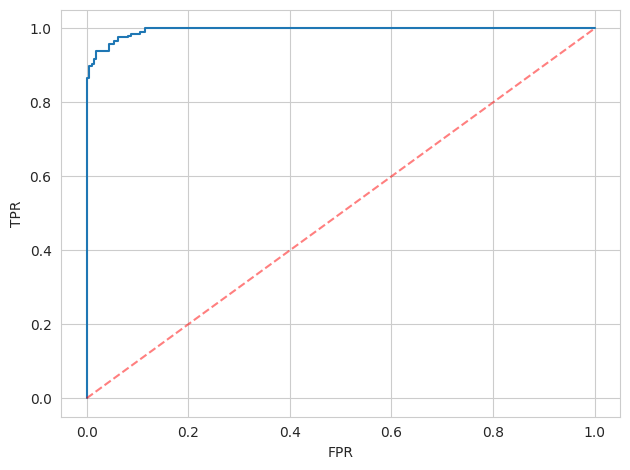

In [16]:
compute_ROC(link_prediction_data)

Not surprisingly, if we use the distance between node positions that were used to generate links, we can predict links with high accuracy.

What if we only observe the network topology, i.e. we do not know the positions of nodes in a underlying space? We can assume that links were generated based on the position of nodes in an underlying *latent space*. Note the Latin origin *latens* for *hidden*. Assuming that such a latent space exists, we are interested in methods to embed nodes into a latent space, such that the positions of nodes ``explain'' the topology of the graph.

We can try something really simple: Considering that our graph was generated from positions in a two-dimensional Euclidean space, we can use the Fruchterman-Reingold algorithm to generate an embedding of nodes based on the topology of the graph. We can then use node positions to calculate similarities, which we use for the link prediction.

 In `pathpy` we can generate a two-dimensional layout of a graph as follows. We use the training network to generate node positions:

In [17]:
train_graph = pp.Graph(link_prediction_data)
layout = pp.layout(train_graph, layout='fr')
print(layout)

{0: array([ 0.13832618, -0.31175098]), 1: array([0.21991023, 0.26657598]), 2: array([ 0.46365129, -0.64497725]), 3: array([ 3.45697353, -0.28377951]), 4: array([0.84336529, 1.15894909]), 5: array([0.63283444, 1.37659977]), 6: array([ 0.1240157, -0.0087098]), 7: array([0.3194892 , 1.15790219]), 8: array([0.66206635, 1.12589006]), 9: array([1.77079499, 3.34502203]), 10: array([-0.19872528,  0.90396716]), 11: array([-0.19792355,  0.29369323]), 12: array([0.09169528, 0.07150392]), 13: array([-0.19101914,  0.84518114]), 14: array([0.16923944, 0.31259296]), 15: array([-0.08540833, -0.38533928]), 16: array([0.69701483, 1.77048135]), 17: array([1.41646605, 0.47027291]), 18: array([-1.42194857, -0.7687168 ]), 19: array([-0.28269302,  0.47707694]), 20: array([-0.19747119,  0.64364441]), 21: array([0.58610635, 1.30119691]), 22: array([1.46990648, 0.43543612]), 23: array([0.51886878, 1.50580228]), 24: array([0.6572777 , 1.59404656]), 25: array([0.1924665 , 1.23787497]), 26: array([0.43937546, 1.29

In [18]:
link_prediction_data.pos = torch.tensor([layout[i] for i in range(train_graph.N)])

/tmp/ipykernel_20/897106964.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  link_prediction_data.pos = torch.tensor([layout[i] for i in range(train_graph.N)])


We use those positions to assign similarity scores to node pairs, which we can use for link prediction.

In [19]:
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)

np.float64(0.916313949208686)

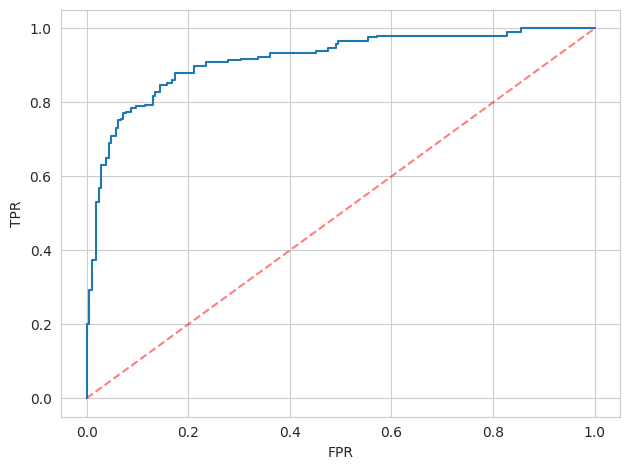

In [20]:
compute_ROC(link_prediction_data)

This simple approach yields an Area Under Curve of 0.95, i.e. for this simple example it works remarkably well.

Without knowing the actual positions of nodes in the latent space, we were able to use the graph topology to recover a representation of nodes in $\mathbb{R}^2$. This representation then allowed us to address link prediction with a high level of accuracy. 

This is a very simple approach to address graph representation learning, where we use the topology of the graph to learn a vector space representation of nodes. Graph representation learning is an important challenge in graph learning and in the following we will address more advanced methods to address it.

As a first idea, we could use the columns of the adjacency matrix as a vector-space representation of nodes:

In [21]:
A = torch.tensor(train_graph.get_sparse_adj_matrix().todense())
link_prediction_data.pos = A

np.float64(0.728422892896577)

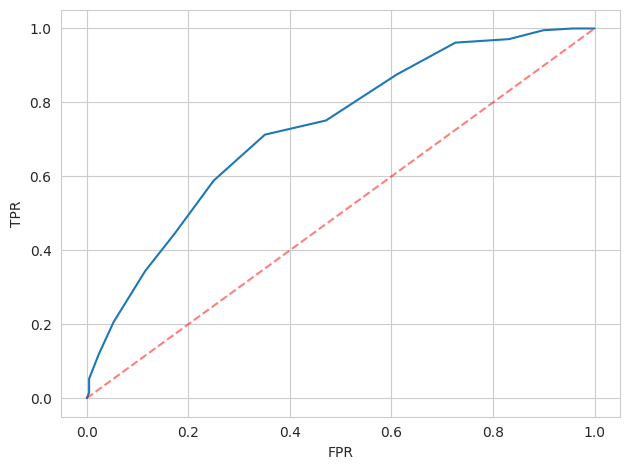

In [22]:
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)
compute_ROC(link_prediction_data)

In [23]:
def cosine_sim(x, y):
    return np.dot(np.ravel(x),np.ravel(y))

np.float64(0.9035011041589989)

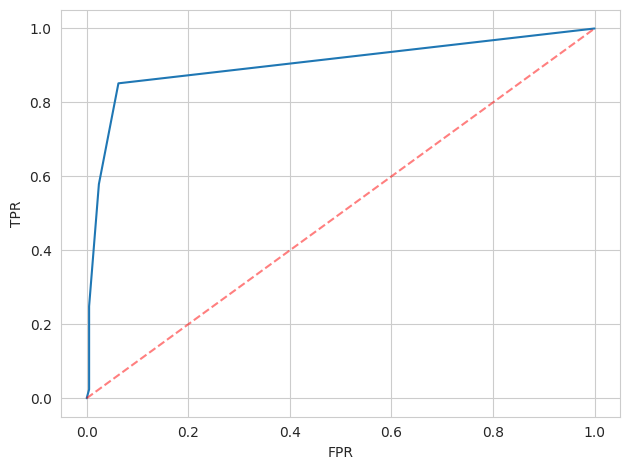

In [24]:
link_prediction_data = assign_sim(link_prediction_data, cosine_sim)
compute_ROC(link_prediction_data)

Using an embedding of nodes in $n$ dimensions is not practical is networks where $n$ is very large. What happens if we try to predict links based on two dimensions only? After all, we know that the latent space that explains the topology of our network has two dimensions.

np.float64(0.5212895656974604)

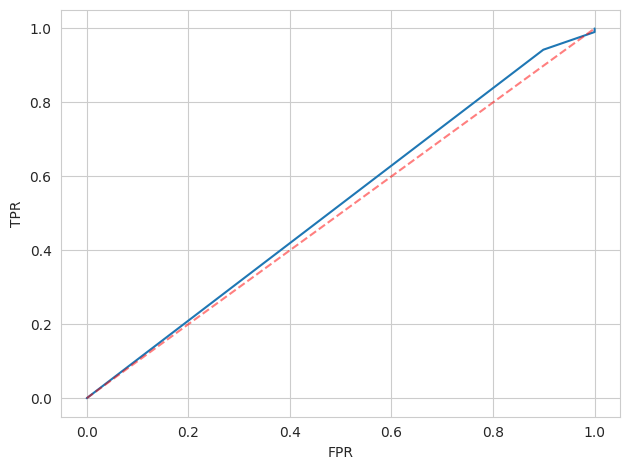

In [25]:
link_prediction_data.pos = link_prediction_data.pos[:,:2]
link_prediction_data = assign_sim(link_prediction_data, euclidean_sim)
compute_ROC(link_prediction_data)

We lose almost all predictive power. In the following experiment, we test the AUC of our link prediction as we gradually increase the number of dimensions in the embedding.

In [26]:
def AUC_dim(
        n=100,
        threshold=0.5,
        data_dim=2,
        # embedding=adjacency_matrix_embedding, # NEEDED??
        max_dim=10,
        samples=10):
    # 1.) generate network 
    n = random_geometric_net(n=100, dist=euclidean_dist, rule=lambda x: True if x < threshold else False, dim=data_dim, lcc=True)

    aucs = []
    for d in range(1, max_dim):
        print('Computing AUC for embedding in {0}-dimensional space'.format(d))
        # 2.) train and test set 
        mean_auc = 0        
        for i in range(samples):
            link_prediction_data= generate_link_prediction_datasets(n)
            train_network = pp.Graph(link_prediction_data)
            vecs = train_network.get_sparse_adj_matrix().todense()[:,:d]
            link_prediction_data.pos = vecs
            link_prediction_data = assign_sim(link_prediction_data,  euclidean_sim)
            mean_auc += compute_ROC(link_prediction_data, plot=False)
        mean_auc = mean_auc / samples
        aucs.append(mean_auc)
    return aucs    

Computing AUC for embedding in 1-dimensional space
Computing AUC for embedding in 2-dimensional space
Computing AUC for embedding in 3-dimensional space
Computing AUC for embedding in 4-dimensional space
Computing AUC for embedding in 5-dimensional space
Computing AUC for embedding in 6-dimensional space
Computing AUC for embedding in 7-dimensional space
Computing AUC for embedding in 8-dimensional space
Computing AUC for embedding in 9-dimensional space


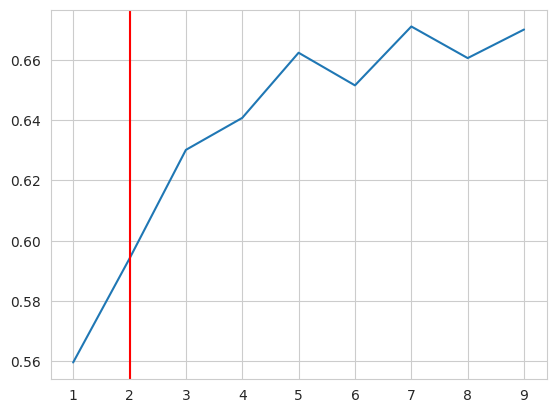

In [27]:
aucs = AUC_dim(data_dim=2, threshold=0.5)
plt.plot(range(1, 10), aucs)
plt.axvline(x=2, color='red');